In [33]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, TimeSeriesSplit
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, make_scorer
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from helper import ResidualBoostClassifier as RBC

# Unidad Energía,GWh,,,,,,,,, for sp_forecasting_test

# Cleaning

In [34]:
df = pd.read_csv('Input Data.csv')

# 2) Normalize the column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(' ', '_')
)

# 3) Parse your date
df['date'] = pd.to_datetime(df['row_labels'], errors='coerce')

# 3) Convert percentage column
df['reservoir_inflows_per'] = (pd.to_numeric(df['reservoir_inflows_per'].str.rstrip(' %'), errors='coerce') / 100)

# Clean numeric columns
num_cols = [
    'electric_demand',
    'reservoir_inflows_gwh',
    'reservoir_gwh',
    'energy_dumping_gwh',
    'cere_copkwh',
    'spot_price_copkwh',
    'scarcity_price_copkwh',
    'thermo_transport_cost_copkwh',
    'thermo_supply_cost_copkwh'
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', '', regex=False), errors='coerce')

# 5)  Drop unused and duplicate rows
df = df.drop(columns=['row_labels']).drop_duplicates()

# 6) Sort by date
df = df.sort_values('date')

# 7) Set date as index
df.set_index('date', inplace=True)

create df

only lag = 1, RMSE 84.55
lag = 1, 2, 3, 4, 5

In [35]:
# Setting it up

# Lag target and exogenous variables
lags = [2, 5, 7, 10]

for lag in lags:
    df[f'spot_lag_{lag}'] = df['spot_price_copkwh'].shift(lag)
    df[f'reservoir_gwh_lag{lag}'] = df['reservoir_gwh'].shift(lag)
    df[f'reservoir_inflows_gwh_lag{lag}'] = df['reservoir_inflows_gwh'].shift(lag)
    df[f'electric_demand_lag{lag}'] = df['electric_demand'].shift(lag)

# Drop rows with any NaNs resulting from shifts
df_model = df.dropna(subset=[f'spot_lag_{lag}' for lag in lags] +
                               [f'reservoir_gwh_lag{lag}' for lag in lags] +
                               [f'reservoir_inflows_gwh_lag{lag}' for lag in lags] +
                               [f'electric_demand_lag{lag}' for lag in lags] +
                               ['spot_price_copkwh'])

# Define feature set
feature_cols = [f'spot_lag_{lag}' for lag in lags] + \
               [f'reservoir_gwh_lag{lag}' for lag in lags] + \
               [f'reservoir_inflows_gwh_lag{lag}' for lag in lags] + \
               [f'electric_demand_lag{lag}' for lag in lags]

X = df_model[feature_cols]
y = df_model['spot_price_copkwh']


In [36]:
from sklearn.base import BaseEstimator, RegressorMixin
from xgboost import XGBRegressor

class XGBSklearnWrapper(BaseEstimator, RegressorMixin):
    def __init__(self,
                 n_estimators=200,
                 learning_rate=0.05,
                 max_depth=5,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 gamma=0,
                 reg_alpha=0,
                 reg_lambda=1,
                 random_state=42):
        self.n_estimators    = n_estimators
        self.learning_rate   = learning_rate
        self.max_depth       = max_depth
        self.subsample       = subsample
        self.colsample_bytree= colsample_bytree
        self.gamma           = gamma
        self.reg_alpha       = reg_alpha
        self.reg_lambda      = reg_lambda
        self.random_state    = random_state

    def fit(self, X, y):
        # instantiate a fresh XGBRegressor with the current params
        self._model = XGBRegressor(
            n_estimators    = self.n_estimators,
            learning_rate   = self.learning_rate,
            max_depth       = self.max_depth,
            subsample       = self.subsample,
            colsample_bytree= self.colsample_bytree,
            gamma           = self.gamma,
            reg_alpha       = self.reg_alpha,
            reg_lambda      = self.reg_lambda,
            random_state    = self.random_state,
            tree_method     = 'hist',     # keep your speed tricks
            verbosity       = 0
        )
        self._model.fit(X, y)
        return self

    def predict(self, X):
        return self._model.predict(X)


Fitting 5 folds for each of 40 candidates, totalling 200 fits

Tuned XGB on 2025:
    Best params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.6}
    Best CV RMSE: 136.9349327998823
    RMSE : 86.68
    MAE  : 60.38
    SMAPE: 13.59%
    MASE : 1.776



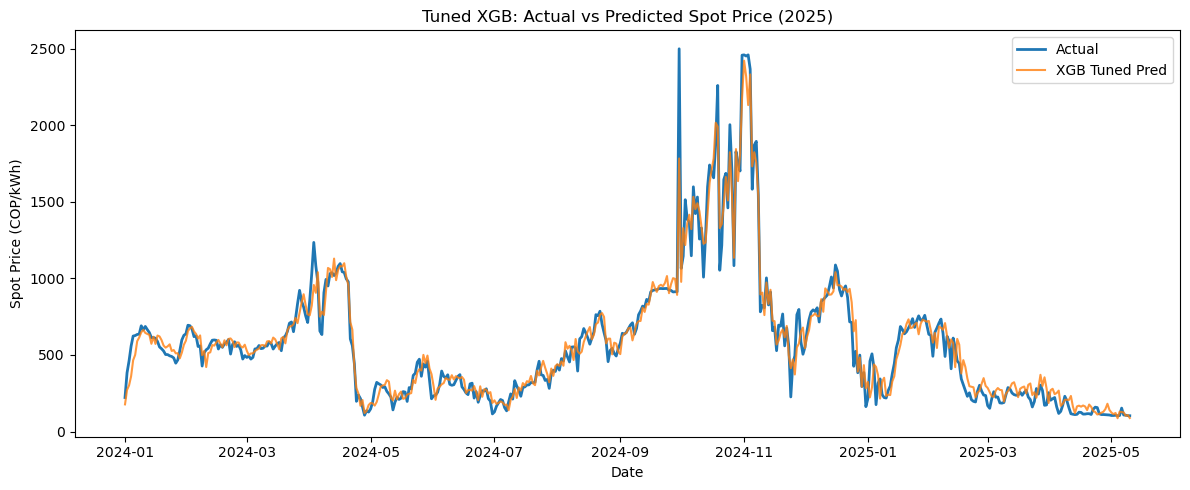

In [37]:
# 1) Prepare train/test split
df_model.index = pd.to_datetime(df_model.index)  # Add this only if not already datetime
train = df_model[(df_model.index.year >= 2019) & (df_model.index.year <= 2024)]
test  = df_model[df_model.index.year >= 2024]

X_train = train[feature_cols]
y_train = train['spot_price_copkwh']
X_test  = test[feature_cols]
y_test  = test['spot_price_copkwh']
dates   = test.index

xgb = XGBSklearnWrapper()

param_dist = {
    'n_estimators':      [50, 100, 200, 300],
    'learning_rate':     [0.01, 0.05, 0.1, 0.2],
    'max_depth':         [3, 5, 7, 9],
    'subsample':         [0.6, 0.8, 1.0],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'gamma':             [0, 1, 5],
    'reg_alpha':         [0, 0.1, 1, 5],
    'reg_lambda':        [1, 2, 5, 10]
}

# 2) TimeSeriesSplit and RandomizedSearchCV as before
tscv = TimeSeriesSplit(n_splits=5)
rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)


# evaluate on 2025 hold-out
best = rs.best_estimator_
y_pred = best.predict(X_test)


rmse_tuned = root_mean_squared_error(y_test, y_pred)   
mae_tuned  = mean_absolute_error(y_test, y_pred)

def smape(y_true, y_pred):
    num = np.abs(y_pred - y_true)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(num/den) * 100

def mase(y_true, y_pred, y_train):
    errors     = np.abs(y_true - y_pred)
    mae_model  = errors.mean()
    naive_errs = np.abs(np.diff(y_train))
    mae_naive  = naive_errs.mean()
    return mae_model / mae_naive

smape_tuned = smape(y_test.values,      y_pred)
mase_tuned  = mase(y_test.values, y_pred, train['spot_price_copkwh'].values)

# print("Best params:", rs.best_params_)
# print("Best CV RMSE:", -rs.best_score_)

print(f"""
Tuned XGB on 2025:
    Best params: {rs.best_params_}
    Best CV RMSE: {-rs.best_score_}
    RMSE : {rmse_tuned:.2f}
    MAE  : {mae_tuned:.2f}
    SMAPE: {smape_tuned:.2f}%
    MASE : {mase_tuned:.3f}
""")

# 7) Plot
plt.figure(figsize=(12,5))
plt.plot(dates, y_test,   label='Actual',        linewidth=2)
plt.plot(dates, y_pred,   label='XGB Tuned Pred', alpha=0.8)
plt.legend()
plt.title('Tuned XGB: Actual vs Predicted Spot Price (2025)')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()



In [38]:
import pandas as pd
import numpy as np
from itertools import combinations
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

# STEP 1: Generate lag features
max_lag = 20
for lag in range(2, max_lag + 1):
    df[f'spot_lag_{lag}'] = df['spot_price_copkwh'].shift(lag)

# STEP 2: Setup
spot_lags = [f'spot_lag_{l}' for l in range(2, max_lag + 1)]
all_combinations = (
    list(combinations(spot_lags, 2)) +
    list(combinations(spot_lags, 3))
    # +list(combinations(spot_lags, 4))
)

results = []

# STEP 3: Loop through all lag combinations
for combo in all_combinations:
    combo = list(combo)
    df_model = df.dropna(subset=combo + ['spot_price_copkwh'])

    # Split
    train = df_model[(df_model.index.year >= 2020) & (df_model.index.year <= 2024)]
    test = df_model[df_model.index.year == 2025]
    if train.empty or test.empty:
        continue

    X_train = train[combo]
    y_train = train['spot_price_copkwh']
    X_test = test[combo]
    y_test = test['spot_price_copkwh']

    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        verbosity=0
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    results.append((combo, rmse))

# STEP 4: Results
results.sort(key=lambda x: x[1])  # sort by RMSE
best_combo, best_rmse = results[0]

print("\nBest Combination of Spot Lag Features:")
print(best_combo)
print(f"Best RMSE: {best_rmse:.2f}")



Best Combination of Spot Lag Features:
['spot_lag_2', 'spot_lag_7', 'spot_lag_14']
Best RMSE: 81.33


4 features
Best Combination of Spot Lag Features:
['spot_lag_2', 'spot_lag_5', 'spot_lag_7', 'spot_lag_10']
Best RMSE: 81.15

3 features
Best Combination of Spot Lag Features:
['spot_lag_2', 'spot_lag_7', 'spot_lag_14']
Best RMSE: 81.33

# Model A Benchmarking, Model B Deployment 

Changed train and test time

/var/folders/dd/2d9p2sm56nd4dvpm4nxg3lmw0000gn/T/ipykernel_4667/1159853892.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_weekend_tomorrow'] = df['is_weekend'].shift(-1).fillna(False).astype(int)
/var/folders/dd/2d9p2sm56nd4dvpm4nxg3lmw0000gn/T/ipykernel_4667/1159853892.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_holiday_tomorrow'] = df['is_holiday'].shift(-1).fillna(False).astype(int)
/var/folders/dd/2d9p2sm56nd4dvpm4nxg3lmw0000gn/T/ipykernel_4667/1159853892.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .


Model A (with lag=1) - Feature Importances:
spot_lag_1: 0.4698
spot_lag_2: 0.3250
is_weekend_tomorrow: 0.0182
electric_demand_lag5: 0.0157
is_weekend_or_holiday_tomorrow: 0.0149
spot_lag_5: 0.0139
spot_lag_10: 0.0127
is_holiday_tomorrow: 0.0107
reservoir_inflows_gwh_lag1: 0.0096
reservoir_gwh_lag5: 0.0096
dayofweek_tomorrow: 0.0087
spot_lag_7: 0.0087
reservoir_gwh_lag7: 0.0085
reservoir_inflows_gwh_lag10: 0.0080
reservoir_gwh_lag10: 0.0075
reservoir_gwh_lag1: 0.0069
electric_demand_lag2: 0.0069
electric_demand_lag7: 0.0067
reservoir_gwh_lag2: 0.0065
month_tomorrow: 0.0061
reservoir_inflows_gwh_lag7: 0.0060
electric_demand_lag1: 0.0059
reservoir_inflows_gwh_lag2: 0.0054
electric_demand_lag10: 0.0050
reservoir_inflows_gwh_lag5: 0.0032

Model A (with lag=1) - Metrics:
  RMSE: 290.74
  MAE: 143.72
  SMAPE: 23.12%
  MASE: 5.900

Model B (no lag=1) - Feature Importances:
spot_lag_2: 0.4694
spot_lag_5: 0.2540
electric_demand_lag5: 0.0322
electric_demand_lag7: 0.0258
electric_demand_lag2: 0.0

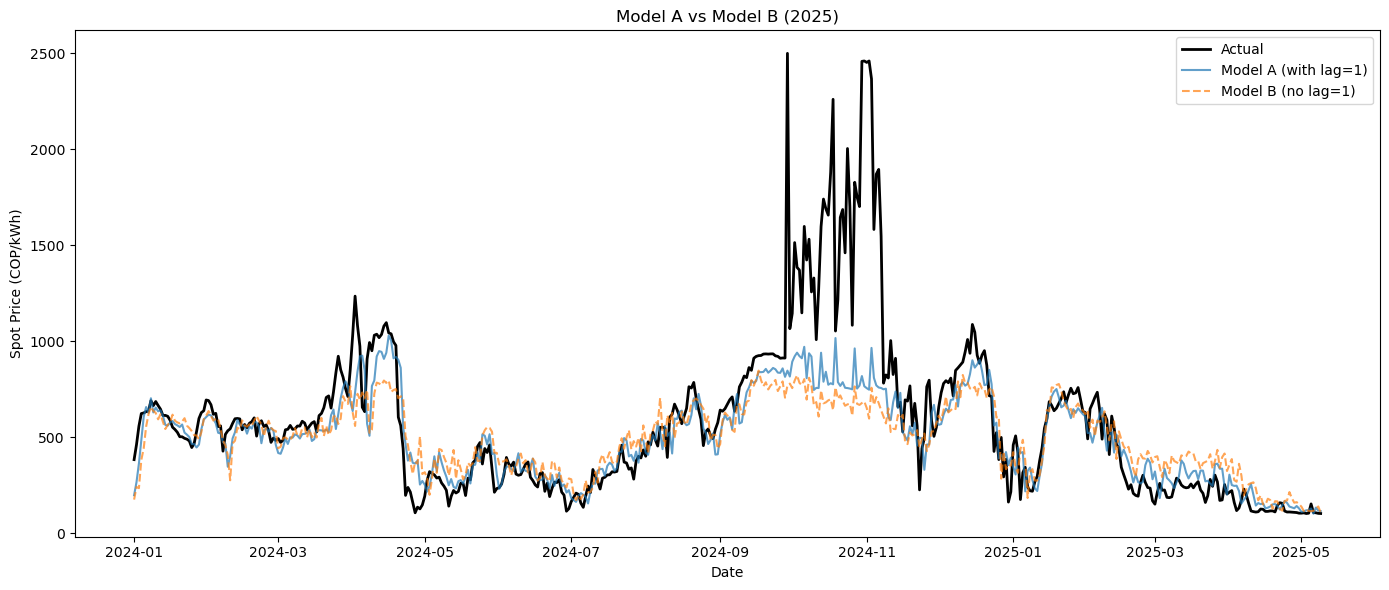

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import holidays

# Convert index to datetime
df.index = pd.to_datetime(df.index, errors='coerce')
df = df[~df.index.isna()]

# Define Colombian holidays
co_holidays = holidays.Colombia(years=range(2020, 2026))

# --- Create base calendar features (for today)
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['dayofweek'] >= 5
df['is_holiday'] = df.index.to_series().apply(lambda d: d in co_holidays)
df['is_weekend_or_holiday'] = df['is_weekend'] | df['is_holiday']

# --- Create calendar features for tomorrow (shifted)
df['is_weekend_tomorrow'] = df['is_weekend'].shift(-1).fillna(False).astype(int)
df['is_holiday_tomorrow'] = df['is_holiday'].shift(-1).fillna(False).astype(int)
df['is_weekend_or_holiday_tomorrow'] = df['is_weekend_or_holiday'].shift(-1).fillna(False).astype(int)
df['dayofweek_tomorrow'] = df['dayofweek'].shift(-1).fillna(method='ffill').astype(int)
df['month_tomorrow'] = df['month'].shift(-1).fillna(method='ffill').astype(int)

# --- Target for t+1 prediction
df['target_spot_price'] = df['spot_price_copkwh'].shift(-1)

def smape(y_true, y_pred):
    num = np.abs(y_pred - y_true)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(num / den) * 100

def mase(y_true, y_pred, y_train):
    errors = np.abs(y_true - y_pred)
    mae_model = errors.mean()
    naive_errors = np.abs(np.diff(y_train))
    mae_naive = naive_errors.mean()
    return mae_model / mae_naive

def run_model(df, lags, label="Model"):
    for lag in lags:
        df[f'spot_lag_{lag}'] = df['spot_price_copkwh'].shift(lag)
        df[f'reservoir_gwh_lag{lag}'] = df['reservoir_gwh'].shift(lag)
        df[f'reservoir_inflows_gwh_lag{lag}'] = df['reservoir_inflows_gwh'].shift(lag)
        df[f'electric_demand_lag{lag}'] = df['electric_demand'].shift(lag)

    feature_cols = (
        [f'spot_lag_{lag}' for lag in lags] +
        [f'reservoir_gwh_lag{lag}' for lag in lags] +
        [f'reservoir_inflows_gwh_lag{lag}' for lag in lags] +
        [f'electric_demand_lag{lag}' for lag in lags] +
        ['is_weekend_tomorrow', 'is_holiday_tomorrow', 'is_weekend_or_holiday_tomorrow',
         'dayofweek_tomorrow', 'month_tomorrow']
    )

    df_model = df.dropna(subset=feature_cols + ['target_spot_price'])
    train = df_model[(df_model.index.year >= 2020) & (df_model.index.year < 2024)]
    test = df_model[df_model.index.year >= 2024]

    X_train = train[feature_cols]
    y_train = train['target_spot_price']
    X_test = test[feature_cols]
    y_test = test['target_spot_price']
    dates = test.index

    model = XGBSklearnWrapper()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    importances = model._model.feature_importances_
    print(f"\n{label} - Feature Importances:")
    for f, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
        print(f"{f}: {imp:.4f}")

    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    smape_val = smape(y_test.values, y_pred)
    mase_val = mase(y_test.values, y_pred, y_train.values)

    print(f"\n{label} - Metrics:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  SMAPE: {smape_val:.2f}%")
    print(f"  MASE: {mase_val:.3f}")

    return dates, y_test, y_pred

# --- Run both models
lags_a = [1, 2, 5, 7, 10]
lags_b = [2, 5, 7, 10]

dates_a, y_test_a, y_pred_a = run_model(df.copy(), lags_a, label="Model A (with lag=1)")
dates_b, y_test_b, y_pred_b = run_model(df.copy(), lags_b, label="Model B (no lag=1)")

# --- Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(dates_a, y_test_a, label='Actual', color='black', linewidth=2)
plt.plot(dates_a, y_pred_a, label='Model A (with lag=1)', alpha=0.7)
plt.plot(dates_b, y_pred_b, label='Model B (no lag=1)', linestyle='--', alpha=0.7)
plt.legend()
plt.title('Model A vs Model B (2025)')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.tight_layout()
plt.show()